## Importe dos Pacotes

Começamos instalando as bibliotecas e importando os pacotes necessários.

`!pip3 install snscrape`

`!pip install tabulate`

`!pip install wordcloud`

`!pip install selenium`

In [131]:
import pandas as pd
import numpy as np
import requests
import time
from bs4 import BeautifulSoup
from selenium import webdriver
import mysql.connector as mdb
from PIL import Image
import nltk
import os
import re
import zipfile
import matplotlib.pyplot as plt
import networkx as nx
import snscrape.modules.twitter as sntwitter
from nltk.sentiment import SentimentIntensityAnalyzer as sia
import seaborn as sns
import itertools
from wordcloud import WordCloud
from tabulate import tabulate
import unicodedata
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from math import pi
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
nltk.download('vader_lexicon')
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\guhhh\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\guhhh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\guhhh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Coleta/Raspagem de Dados

Criando um conector do SQL para armazenar nossos dados de maneira profissional. 

In [2]:
con = mdb.connect(user='root', password ='*********')
cursor = con.cursor()

Num primeiro passo, definimos uma lista com o nome dos clubes do campeonato e seus respectivos apelidos mais utilizados pelos torcedores (termos chave).

In [3]:
pl = ['(Man City OR Cityzens)', '(Liverpool OR Reds)',
               '(Chelsea OR Blues)', '(Tottenham OR Lilywhites OR Spurs)', '(Arsenal OR Gunners)', 
                'Man United', '(West Ham OR Hammers OR Irons)',
               '(Leicester OR Foxes)', '(Brighton OR Seagulls)', '(Wolverhampton OR Wolves)',
                '(Newcastle OR Magpies OR Toon OR Geordies)', '(Crystal Palace OR Palace OR Eagles)',
               '(Brentford OR Bees)', '(Aston Villa OR Villa OR Villans OR Lions)', '(Southampton OR Saints)',
               '(Everton OR Toffees OR Toffeemen)', '(Leeds OR Whites OR Peacocks)', '(Burnley OR Clarets)',
               '(Watford OR Hornets)', '(Norwich OR Canaries OR Yellows)']
pl

['(Man City OR Cityzens)',
 '(Liverpool OR Reds)',
 '(Chelsea OR Blues)',
 '(Tottenham OR Lilywhites OR Spurs)',
 '(Arsenal OR Gunners)',
 'Man United',
 '(West Ham OR Hammers OR Irons)',
 '(Leicester OR Foxes)',
 '(Brighton OR Seagulls)',
 '(Wolverhampton OR Wolves)',
 '(Newcastle OR Magpies OR Toon OR Geordies)',
 '(Crystal Palace OR Palace OR Eagles)',
 '(Brentford OR Bees)',
 '(Aston Villa OR Villa OR Villans OR Lions)',
 '(Southampton OR Saints)',
 '(Everton OR Toffees OR Toffeemen)',
 '(Leeds OR Whites OR Peacocks)',
 '(Burnley OR Clarets)',
 '(Watford OR Hornets)',
 '(Norwich OR Canaries OR Yellows)']

Criamos, em seguida, uma função lambda que mapeia o nome dos clubes por seus respectivos apelidos, criando, assim, uma coluna onde cada linha referencia o nome de um clube associado ao twiiter sobre ele.

In [5]:
class MissingDict1(dict):
    __missing__ = lambda self, key: key

map_values1 = {"(Man City OR Cityzens)": "Manchester City",
              "(Liverpool OR Reds)": "Liverpool",
              "(Chelsea OR Blues)": "Chelsea",
              "(Arsenal OR Gunners)": "Arsenal",
              "(Leicester OR Foxes)": "Leicester",
              "(Brighton OR Seagulls)": "Brighton",
              "Man United": "Manchester Utd",
              "(Newcastle OR Magpies OR Toon OR Geordies)": "Newcastle Utd",
              "(Tottenham OR Lilywhites OR Spurs)": "Tottenham",
              "(West Ham OR Hammers OR Irons)": "West Ham",
              "(Wolverhampton OR Wolves)": "Wolves",
              "(Crystal Palace OR Palace OR Eagles)": "Crystal Palace",
              "(Brentford OR Bees)": "Brentford",
              "(Aston Villa OR Villa OR Villans OR Lions)": "Aston Villa",
              "(Southampton OR Saints)": "Southampton",
              "(Everton OR Toffees OR Toffeemen)": "Everton",
              "(Leeds OR Whites OR Peacocks)": "Leeds",
              "(Burnley OR Clarets)": "Burnley",
              "(Watford OR Hornets)": "Watford",
              "(Norwich OR Canaries OR Yellows)": "Norwich"}
mapping1 = MissingDict1(**map_values1)

Utilizando o modulo do twitter da blibioteca snscrape, coletamos os tweets relativos aos clubes da Premier League (PL).
Para isso, aplicamos uma função que formata as entradas de texto do df de modo compatível com a syntax do SQL, uma outra para listar todas as semanas da temporada e uma para coletar dos dados.

In [3]:
def strip_accents(text):
    try:
        text = unicode(text, 'utf-8')
    except (TypeError, NameError):  
        pass
    text = unicodedata.normalize('NFD', text)
    text = text.encode('ascii', 'ignore')
    text = text.decode("utf-8")
    return str(text)

def text_to_sql(text):
    text = strip_accents(text.lower())
    text = re.sub('[^@$!?&.#0-9a-zA-Z_-]'," ", text)
    text= text.lstrip()
    return text

In [7]:
def all_weeks(date):
    return pd.date_range(start=str(date),
                        end=str('2022-05-15'),
                        freq="W").strftime("""
                                           %Y-%m-%d""").tolist()

In [ ]:
def weekly_data(week, keywords):
    week = pd.to_datetime(week)
    until = week.strftime('%Y-%m-%d')
    since = (week - pd.to_timedelta(1, 'W')).strftime('%Y-%m-%d')
    query = str(keywords) + ' AND (premier league OR pl) lang:en min_faves:0 since:{} until:{}'.format(since, until)
    tweets_list = []
    for tweet in itertools.islice(sntwitter.TwitterSearchScraper(query).get_items(), 0,5000,None):
        fields = {}
        date = str(tweet.date)     
        text = str(tweet.content)
        text = strip_accents(text)
        text = text_to_sql(text)
        username = str(tweet.user.username)
        favorites = str(tweet.likeCount)
        retweets = str(tweet.retweetCount)
        keyterm = str(keywords)
        fields['datetime'] = date
        fields['username'] = username
        fields['text'] = text
        fields['favorites'] = favorites
        fields['retweets'] = retweets
        fields['keyterm'] = keyterm
        tweets_list.append(fields)
    data = pd.DataFrame(tweets_list)
    return data

Aqui, definimos uma função da qual utilizamos a library de Machine Learning SentimentIntensityAnalyzer para identificar o sentimento que tais tweets sobre os clubes expressam, se são positivos, negativos ou neutros.

In [9]:
def sentiment(tweet: str) -> bool:      
    if sia().polarity_scores(tweet)["compound"]>0:
        return 'positive'
    elif sia().polarity_scores(tweet)["compound"]<0:
        return 'negative'
    elif sia().polarity_scores(tweet)["compound"]==0:
        return 'neutral'

Aqui temos o loop para realizar a coleta com o devido corte temporal de interesse, a aplicação da função de sentimento e algumas manipulações de nosso df, para no final, salva-lo em um arquivo csv.

In [ ]:
x = all_weeks('2021-08-07')
f = []
for i in range(0, len(pl)):
    for j in range(0, len(x)):
        w = weekly_data(x[j], pl[i])
        f.append(w)
df1 = pd.concat(f)
df1['sentiment']=df1.loc[:, 'text'].apply( lambda x: sentiment(x))
df1['datetime'] = pd.to_datetime(df1.datetime, format='%Y-%m-%d')
df1['date'] = df1['datetime'].dt.date
df1["team"] = df1["keyterm"].map(mapping1)
df1.to_csv('C:/Users/guhhh/OneDrive/Área de Trabalho/Workspace/modeloPL/tts_pl_teams.csv')

Criaremos agora nossa database no SQL, de modo a armazenar todos os dados deste projeto nela.

In [5]:
query_db = "CREATE DATABASE modelopl"
cursor.execute(query_db)

In [4]:
# Selecionando nossa database
query_sdb = "USE modelopl"
cursor.execute(query_sdb)

Para automatizar o processo, criamos abaixo uma função que escreve nossa query de criação da tabela na database do SQL.

In [53]:
def create_tb(n, lista):
    l = ["CREATE TABLE " + str(n) + " ("]
    for i in range(0, (len(lista)-1)):
        q = lista[i] + ' TEXT NOT NULL,'
        l.append(q)
    l.append(lista[-1] + " TEXT NOT NULL)")
    query = ' '.join([str(item) for item in l])
    return query

In [48]:
cols = df1.columns.tolist()
cols

['datetime',
 'username',
 'text',
 'favorites',
 'retweets',
 'keyterm',
 'sentiment',
 'date',
 'team']

In [54]:
query_tb = create_tb('ttspl',cols)
query_tb

'CREATE TABLE ttspl ( datetime TEXT NOT NULL, username TEXT NOT NULL, text TEXT NOT NULL, favorites TEXT NOT NULL, retweets TEXT NOT NULL, keyterm TEXT NOT NULL, sentiment TEXT NOT NULL, date TEXT NOT NULL, team TEXT NOT NULL)'

In [15]:
# Criando agora a tabela em nosso servidor SQL, dentro da database que acabamos de gerar acima, de modo a armazenar o df dos tts
cursor.execute(query_tb)

In [17]:
# Armazenando o df dos tts
for i in range(0, len(df1)):
    query_insert = ("INSERT INTO ttspl (datetime, username, text, favorites, retweets, keyterm, sentiment, date, team) values ('%s', '%s', '%s', '%s', '%s', '%s', '%s', '%s', '%s')" % (df1.datetime[i], df1.username[i], df1.text[i], df1.favorites[i], df1.retweets[i], df1.keyterm[i], df1.sentiment[i], df1.date[i], df1.team[i]))
    cursor.execute(query_insert)

Abaixo construimos uma função para ler as tabelas do SQL no python.

In [5]:
def read_table(table):
    query = "SELECT * FROM " + table
    return pd.read_sql(query,con)

In [19]:
df1 = read_table("ttspl")
# Dado que o processo de armazenamento de uma base faz com suas variáveis passem para o formato 'object', temos que ajustá-las
df1['datetime'] = pd.to_datetime(df1.datetime, format='%Y-%m-%d')
df1['date'] = pd.to_datetime(df1.date, format='%Y-%m-%d')
df1['favorites'] = df1.favorites.astype(int)
df1['retweets'] = df1.retweets.astype(int)
df1

,datetime,username,text,favorites,retweets,keyterm,sentiment,date,team
0,2021-08-07 23:50:02+00:00,CalcioArgentino,man city broke the british transfer record thi...,1,0,(Man City OR Cityzens),negative,2021-08-07,Manchester City
1,2021-08-07 23:20:15+00:00,Spinning_headz,@kieranmaguire english fans have sat mute for ...,1,0,(Man City OR Cityzens),positive,2021-08-07,Manchester City
2,2021-08-07 21:57:25+00:00,Czooba,manchester united needs to avoid conceding car...,4129,280,(Man City OR Cityzens),negative,2021-08-07,Manchester City
3,2021-08-07 21:53:55+00:00,BBrownCFCVT,@hornbecksteve1 @simonbrundish you got 1 premi...,1,0,(Man City OR Cityzens),negative,2021-08-07,Manchester City
4,2021-08-07 21:47:32+00:00,MidwestMadDog,so glad the premier league starts next week. m...,3,2,(Man City OR Cityzens),positive,2021-08-07,Manchester City
...,...,...,...,...,...,...,...,...,...
978665,2022-05-15 03:55:05+00:00,marinadenhlokzn,@lada_dala @mithisa_motho @curtis_peprah @gomo...,0,0,Man United,positive,2022-05-15,Manchester Utd
978666,2022-05-15 02:27:43+00:00,CharlieKime1,@jackiefroge @sportsnet true its not even clo...,2,1,Man United,positive,2022-05-15,Manchester Utd
978667,2022-05-15 01:28:03+00:00,CathalF94,@sporf @lfc @manutd @premierleague fist pumps ...,2,0,Man United,neutral,2022-05-15,Manchester Utd
978668,2022-05-15 01:21:20+00:00,BigSledge03,@mufc1908 man united even at its current shit...,0,0,Man United,positive,2022-05-15,Manchester Utd


In [20]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 978670 entries, 0 to 978669
Data columns (total 9 columns):
 #   Column     Non-Null Count   Dtype              
---  ------     --------------   -----              
 0   datetime   978670 non-null  datetime64[ns, UTC]
 1   username   978670 non-null  object             
 2   text       978670 non-null  object             
 3   favorites  978670 non-null  int32              
 4   retweets   978670 non-null  int32              
 5   keyterm    978670 non-null  object             
 6   sentiment  978670 non-null  object             
 7   date       978670 non-null  datetime64[ns]     
 8   team       978670 non-null  object             
dtypes: datetime64[ns, UTC](1), datetime64[ns](1), int32(2), object(5)
memory usage: 59.7+ MB


In [24]:
# Sempre utilizar este comando para salvar todas as tarefas realizadas no servidor SQL
con.commit()

Começamos aqui o processo de coleta das informações referentes as partidas disputadas pelos clubes da PL nas últimas temporadas.

In [20]:
# Criando uma lista de anos
years = list(range(2022,2020,-1))
all_matches = []

In [21]:
# URL do site
url = "https://fbref.com/en/comps/9/11160/2021-2022-Premier-League-Stats"

O código tende a dar erros muitas vezes. Isso ocorre pois o site bloqueia o acesso. Por este motivo, recorremos a um tempo de 5 segundos em casa loop. Mesmo assim, bugs podem ocorrer. 

In [ ]:
for year in years:
    data = requests.get(url)
    soup = BeautifulSoup(data.text)
    table = soup.select('table.stats_table')[0]

    links = [l.get("href") for l in table.find_all('a')]
    links = [l for l in links if '/squads/' in l]
    team_urls = [f"https://fbref.com{l}" for l in links]
    
    previous_season = soup.select("a.prev")[0].get("href")
    url = f"https://fbref.com{previous_season}"
    
    for team_url in team_urls:
        team_name = team_url.split("/")[-1].replace("-Stats", "").replace("-", " ")
        
        data = requests.get(team_url)
        matches = pd.read_html(data.text, match="Scores & Fixtures")[0]
        soup = BeautifulSoup(data.text)
        links = [l.get("href") for l in soup.find_all('a')]
        links = [l for l in links if l and 'all_comps/shooting/' in l]
        data = requests.get(f"https://fbref.com{links[0]}")
        shooting = pd.read_html(data.text, match="Shooting")[0]
        shooting.columns = shooting.columns.droplevel()
        
        try:
            team_data = matches.merge(shooting[["Date", "Sh", "SoT", "Dist", "FK", "PK", "PKatt"]], on="Date")
        except ValueError:
            continue
        team_data = team_data[team_data["Comp"] == "Premier League"]
        
        team_data["Season"] = year
        team_data["Team"] = team_name
        all_matches.append(team_data)
        time.sleep(5)

In [ ]:
# Concatenando todas as partidas
match_df = pd.concat(all_matches)

In [ ]:
match_df.columns = [c.lower() for c in match_df.columns]
match_df

In [ ]:
# Criando lista de anos 
years = list(range(2020,2018,-1))
all_matches1 = []

In [ ]:
url1 = "https://fbref.com/en/comps/9/2019-2020/2019-2020-Premier-League-Stats"

In [ ]:
for year in years:
    data = requests.get(url1)
    soup = BeautifulSoup(data.text)
    table = soup.select('table.stats_table')[0]

    links = [l.get("href") for l in table.find_all('a')]
    links = [l for l in links if '/squads/' in l]
    team_urls = [f"https://fbref.com{l}" for l in links]
    
    previous_season = soup.select("a.prev")[0].get("href")
    url1 = f"https://fbref.com{previous_season}"
    
    for team_url in team_urls:
        team_name = team_url.split("/")[-1].replace("-Stats", "").replace("-", " ")
        
        data = requests.get(team_url)
        matches = pd.read_html(data.text, match="Scores & Fixtures")[0]
        soup = BeautifulSoup(data.text)
        links = [l.get("href") for l in soup.find_all('a')]
        links = [l for l in links if l and 'all_comps/shooting/' in l]
        data = requests.get(f"https://fbref.com{links[0]}")
        shooting = pd.read_html(data.text, match="Shooting")[0]
        shooting.columns = shooting.columns.droplevel()
        
        try:
            team_data = matches.merge(shooting[["Date", "Sh", "SoT", "Dist", "FK", "PK", "PKatt"]], on="Date")
        except ValueError:
            continue
        team_data = team_data[team_data["Comp"] == "Premier League"]
        
        team_data["Season"] = year
        team_data["Team"] = team_name
        all_matches1.append(team_data)
        time.sleep(4)

In [ ]:
# Concatenando todas as partidas
match_df1 = pd.concat(all_matches1)

In [ ]:
match_df1.columns = [c.lower() for c in match_df1.columns]
match_df1

In [ ]:
# Concatenando os dois dfs
all_season = pd.concat([match_df,match_df1])

In [ ]:
# Salvando df em formato csv
all_season.to_csv("match_4season.csv")

Nesta etapa realizamos a raspagem da série do índice SPI, que busca medir a força dos clubes.

In [132]:
driver = webdriver.Chrome()

In [133]:
# Entrando no site do FiveThirtyEight
driver.get("https://data.fivethirtyeight.com/#soccer-spi")

In [134]:
# Clicando no botão de download para baixar as tabelas com os ídnices SPI de cada clube da PL
driver.find_element("xpath", '/html/body/div[2]/div[2]/table[1]/tbody/tr[1]/td[5]/div').click()

IMPORTANTE: O output do código acima pode variar, dado que a referida tabela do link se ordena de acordo com a atualização das bases. No código, especificamente, o que vai variar será índice do trecho 'tr[1]'.

In [135]:
# Fechando o driver
driver.quit()

In [2]:
# Movendo os arquivos zipados para o diretório do código
os.replace("C:\\Users\\guhhh\\Downloads\\soccer-spi.zip", "C:\\Users\\guhhh\\OneDrive\\Área de Trabalho\\Workspace\\modeloPL\\script\\soccer-spi.zip")

In [11]:
dir = os.getcwd()

In [12]:
# Deszipando os files que contem a série do SPI
with zipfile.ZipFile('C:\\Users\\guhhh\\OneDrive\\Área de Trabalho\\Workspace\\modeloPL\\script\\soccer-spi.zip', 'r') as zip_ref:
    zip_ref.extractall(dir)

In [6]:
# https://data.fivethirtyeight.com/#soccer-spi site para baixar o índice SPI
df_spi = pd.read_csv("soccer-spi\\spi_matches.csv")
df_match = pd.read_csv("match_4season.csv")

In [7]:
# Eliminando temporadas que não serão utilizadas
years = [2016,2017,2022]
df_spi = df_spi[df_spi.season.isin(years)==False]

In [8]:
#Selecionando apenas os dados da PL
df_spi = df_spi[df_spi["league"]=="Barclays Premier League"]

In [10]:
# Selecionando as colunas que iremos utilizar no modelo
data =  df_spi[["season","league","date","team1","team2","spi1","spi2","nsxg1","nsxg2"]]
data

,season,league,date,team1,team2,spi1,spi2,nsxg1,nsxg2
11781,2018,Barclays Premier League,2018-08-10,Manchester United,Leicester City,82.66,69.64,0.71,1.80
11801,2018,Barclays Premier League,2018-08-11,Newcastle,Tottenham Hotspur,67.21,85.75,1.60,1.50
11821,2018,Barclays Premier League,2018-08-11,Huddersfield Town,Chelsea,60.20,84.39,0.94,1.35
11826,2018,Barclays Premier League,2018-08-11,AFC Bournemouth,Cardiff City,62.75,59.47,2.28,1.16
11844,2018,Barclays Premier League,2018-08-11,Watford,Brighton and Hove Albion,66.07,63.08,2.11,0.98
...,...,...,...,...,...,...,...,...,...
55411,2021,Barclays Premier League,2022-05-22,Chelsea,Watford,88.30,55.41,1.72,1.04
55412,2021,Barclays Premier League,2022-05-22,Norwich City,Tottenham Hotspur,48.57,83.25,0.98,2.10
55414,2021,Barclays Premier League,2022-05-22,Burnley,Newcastle,64.16,71.58,1.68,0.57
55415,2021,Barclays Premier League,2022-05-22,Arsenal,Everton,78.94,65.91,2.60,0.53


Aqui, filtramos nosso df com as colunas das datas, dos times, do spi e da varíavel nsxg.

In [11]:
data_team = data[["date","team1","spi1","nsxg1"]]
data_team

,date,team1,spi1,nsxg1
11781,2018-08-10,Manchester United,82.66,0.71
11801,2018-08-11,Newcastle,67.21,1.60
11821,2018-08-11,Huddersfield Town,60.20,0.94
11826,2018-08-11,AFC Bournemouth,62.75,2.28
11844,2018-08-11,Watford,66.07,2.11
...,...,...,...,...
55411,2022-05-22,Chelsea,88.30,1.72
55412,2022-05-22,Norwich City,48.57,0.98
55414,2022-05-22,Burnley,64.16,1.68
55415,2022-05-22,Arsenal,78.94,2.60


Renomeamos os títulos das colunas retirando o nº 1 do final.

In [12]:
data_team = data_team.rename(columns={"team1":"team","spi1":"spi","nsxg1":"nsxg"})
data_team

,date,team,spi,nsxg
11781,2018-08-10,Manchester United,82.66,0.71
11801,2018-08-11,Newcastle,67.21,1.60
11821,2018-08-11,Huddersfield Town,60.20,0.94
11826,2018-08-11,AFC Bournemouth,62.75,2.28
11844,2018-08-11,Watford,66.07,2.11
...,...,...,...,...
55411,2022-05-22,Chelsea,88.30,1.72
55412,2022-05-22,Norwich City,48.57,0.98
55414,2022-05-22,Burnley,64.16,1.68
55415,2022-05-22,Arsenal,78.94,2.60


Aplicamos, aqui, o mesmo procedimento feito acima. Eliminamos o indice 2 dos titulos das colunas renomeandos.

In [13]:
# Renomeando para fazer o merge.
data_team1 = data[["date","team2","spi2","nsxg2"]]
data_team1 = data_team1.rename(columns={"team2":"team","spi2":"spi","nsxg2":"nsxg"})
data_team1

,date,team,spi,nsxg
11781,2018-08-10,Leicester City,69.64,1.80
11801,2018-08-11,Tottenham Hotspur,85.75,1.50
11821,2018-08-11,Chelsea,84.39,1.35
11826,2018-08-11,Cardiff City,59.47,1.16
11844,2018-08-11,Brighton and Hove Albion,63.08,0.98
...,...,...,...,...
55411,2022-05-22,Watford,55.41,1.04
55412,2022-05-22,Tottenham Hotspur,83.25,2.10
55414,2022-05-22,Newcastle,71.58,0.57
55415,2022-05-22,Everton,65.91,0.53


Agora, antes de aplicar o merge, concatenamos em uma mesma coluna os elementos referentes aos titulos: date, team, spi e nsxg.

In [14]:
df_teamC = pd.concat([data_team,data_team1])
df_teamC

,date,team,spi,nsxg
11781,2018-08-10,Manchester United,82.66,0.71
11801,2018-08-11,Newcastle,67.21,1.60
11821,2018-08-11,Huddersfield Town,60.20,0.94
11826,2018-08-11,AFC Bournemouth,62.75,2.28
11844,2018-08-11,Watford,66.07,2.11
...,...,...,...,...
55411,2022-05-22,Watford,55.41,1.04
55412,2022-05-22,Tottenham Hotspur,83.25,2.10
55414,2022-05-22,Newcastle,71.58,0.57
55415,2022-05-22,Everton,65.91,0.53


Fazemos então o merge e eliminamos as linhas duplicadas.

In [15]:
# Fazendo o merge
data_consolidada = pd.merge(df_match,df_teamC,how='inner',on=["date","team"])
data_consolidada = data_consolidada.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1)
data_consolidada

,date,time,comp,round,day,venue,result,gf,ga,opponent,...,sh,sot,dist,fk,pk,pkatt,season,team,spi,nsxg
0,2021-08-15,16:30,Premier League,Matchweek 1,Sun,Away,L,0,1,Tottenham,...,18.0,4.0,16.9,1.0,0.0,0.0,2022,Manchester City,91.76,2.03
1,2021-08-15,16:30,Premier League,Matchweek 1,Sun,Away,L,0,1,Tottenham,...,18.0,4.0,16.9,1.0,0.0,0.0,2022,Manchester City,91.76,2.03
2,2021-08-15,16:30,Premier League,Matchweek 1,Sun,Away,L,0,1,Tottenham,...,18.0,4.0,16.9,1.0,0.0,0.0,2022,Manchester City,91.76,2.03
3,2021-08-15,16:30,Premier League,Matchweek 1,Sun,Away,L,0,1,Tottenham,...,18.0,4.0,16.9,1.0,0.0,0.0,2022,Manchester City,91.76,2.03
4,2021-08-21,15:00,Premier League,Matchweek 2,Sat,Home,W,5,0,Norwich City,...,16.0,4.0,17.3,1.0,0.0,0.0,2022,Manchester City,91.64,2.12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4023,2019-04-13,12:30,Premier League,Matchweek 34,Sat,Away,L,0,4,Tottenham,...,7.0,1.0,18.1,1.0,0.0,0.0,2019,Huddersfield Town,52.04,0.73
4024,2019-04-20,15:00,Premier League,Matchweek 35,Sat,Home,L,1,2,Watford,...,13.0,3.0,17.5,1.0,0.0,0.0,2019,Huddersfield Town,51.83,0.63
4025,2019-04-26,20:00,Premier League,Matchweek 36,Fri,Away,L,0,5,Liverpool,...,5.0,1.0,22.8,0.0,0.0,0.0,2019,Huddersfield Town,51.84,0.19
4026,2019-05-05,14:00,Premier League,Matchweek 37,Sun,Home,D,1,1,Manchester Utd,...,7.0,3.0,18.8,1.0,0.0,0.0,2019,Huddersfield Town,51.35,0.77


In [162]:
matches = data_consolidada.drop_duplicates(subset=['date', 'time', 'opponent', 'team','season'])
matches = matches.drop(['match report', 'round', 'formation', 'notes'], axis=1)
matches.dropna(inplace=True)
matches.reset_index(drop=True, inplace=True)
matches

,date,time,comp,day,venue,result,gf,ga,opponent,xg,...,sh,sot,dist,fk,pk,pkatt,season,team,spi,nsxg
0,2021-08-15,16:30,Premier League,Sun,Away,L,0,1,Tottenham,1.9,...,18.0,4.0,16.9,1.0,0.0,0.0,2022,Manchester City,91.76,2.03
1,2021-08-21,15:00,Premier League,Sat,Home,W,5,0,Norwich City,2.7,...,16.0,4.0,17.3,1.0,0.0,0.0,2022,Manchester City,91.64,2.12
2,2021-08-28,12:30,Premier League,Sat,Home,W,5,0,Arsenal,3.8,...,25.0,10.0,14.3,0.0,0.0,0.0,2022,Manchester City,92.21,3.47
3,2021-09-11,15:00,Premier League,Sat,Away,W,1,0,Leicester City,2.9,...,25.0,8.0,14.0,0.0,0.0,0.0,2022,Manchester City,93.26,2.60
4,2021-09-18,15:00,Premier League,Sat,Home,D,0,0,Southampton,1.1,...,16.0,1.0,15.7,1.0,0.0,0.0,2022,Manchester City,93.48,1.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2362,2019-04-13,12:30,Premier League,Sat,Away,L,0,4,Tottenham,0.6,...,7.0,1.0,18.1,1.0,0.0,0.0,2019,Huddersfield Town,52.04,0.73
2363,2019-04-20,15:00,Premier League,Sat,Home,L,1,2,Watford,0.8,...,13.0,3.0,17.5,1.0,0.0,0.0,2019,Huddersfield Town,51.83,0.63
2364,2019-04-26,20:00,Premier League,Fri,Away,L,0,5,Liverpool,0.1,...,5.0,1.0,22.8,0.0,0.0,0.0,2019,Huddersfield Town,51.84,0.19
2365,2019-05-05,14:00,Premier League,Sun,Home,D,1,1,Manchester Utd,1.1,...,7.0,3.0,18.8,1.0,0.0,0.0,2019,Huddersfield Town,51.35,0.77


In [17]:
# Salvando em formato csv
matches.to_csv("matches.csv")

Abaixo, vamos armazenar este df em SQL, seguindo o mesmo procedimento realizado com o df dos tts.

In [164]:
# Utilizando um loop para passar a função de conversão das colunas de texto para um formato compatível com a syntax do SQL
for i in range(0, len(matches)):
    matches.replace(matches.captain[i], text_to_sql(matches.captain[i]), inplace=True)
    matches.replace(matches.referee[i], text_to_sql(matches.referee[i]), inplace=True)
matches.captain

0                 fernandinho
1              ilkay gundogan
2              ilkay gundogan
3              ilkay gundogan
4                 fernandinho
                ...          
2362    christopher schindler
2363    christopher schindler
2364    christopher schindler
2365    christopher schindler
2366    christopher schindler
Name: captain, Length: 2367, dtype: object

In [154]:
matches.referee

0        anthony taylor
1          graham scott
2       martin atkinson
3          paul tierney
4         jonathan moss
             ...       
2362          lee mason
2363         roger east
2364       kevin friend
2365          lee mason
2366        lee probert
Name: referee, Length: 2367, dtype: object

In [165]:
cols = matches.columns.tolist()
cols

['date',
 'time',
 'comp',
 'day',
 'venue',
 'result',
 'gf',
 'ga',
 'opponent',
 'xg',
 'xga',
 'poss',
 'attendance',
 'captain',
 'referee',
 'sh',
 'sot',
 'dist',
 'fk',
 'pk',
 'pkatt',
 'season',
 'team',
 'spi',
 'nsxg']

In [166]:
query_tb = create_tb('matchespl', cols)
query_tb

'CREATE TABLE matchespl ( date TEXT NOT NULL, time TEXT NOT NULL, comp TEXT NOT NULL, day TEXT NOT NULL, venue TEXT NOT NULL, result TEXT NOT NULL, gf TEXT NOT NULL, ga TEXT NOT NULL, opponent TEXT NOT NULL, xg TEXT NOT NULL, xga TEXT NOT NULL, poss TEXT NOT NULL, attendance TEXT NOT NULL, captain TEXT NOT NULL, referee TEXT NOT NULL, sh TEXT NOT NULL, sot TEXT NOT NULL, dist TEXT NOT NULL, fk TEXT NOT NULL, pk TEXT NOT NULL, pkatt TEXT NOT NULL, season TEXT NOT NULL, team TEXT NOT NULL, spi TEXT NOT NULL, nsxg TEXT NOT NULL)'

In [168]:
# Criando a tabela no servidor SQL
cursor.execute(query_tb)

In [159]:
def insert_tb(n, data):
    l = ["INSERT INTO " + str(n) + " ("]
    for i in range(0, (len(data.columns.tolist())-1)):
        q = data.columns.tolist()[i] + ','
        l.append(q)
    l.append(data.columns.tolist()[-1] + ") values (")
    l.append("'%s', "*(len(data.columns.tolist())-1))
    l.append("'%s')")
    query = ' '.join([str(item) for item in l])
    return query

In [169]:
insert = insert_tb('matchespl', matches)
insert

"INSERT INTO matchespl ( date, time, comp, day, venue, result, gf, ga, opponent, xg, xga, poss, attendance, captain, referee, sh, sot, dist, fk, pk, pkatt, season, team, spi, nsxg) values ( '%s', '%s', '%s', '%s', '%s', '%s', '%s', '%s', '%s', '%s', '%s', '%s', '%s', '%s', '%s', '%s', '%s', '%s', '%s', '%s', '%s', '%s', '%s', '%s',  '%s')"

In [170]:
# Armazenando o df dos tts
for i in range(0, len(matches)):
    query_insert = insert % (matches.date[i],
                             matches.time[i],
                             matches.comp[i],
                             matches.day[i],
                             matches.venue[i],
                             matches.result[i],
                             matches.gf[i],
                             matches.ga[i],
                             matches.opponent[i],
                             matches.xg[i],
                             matches.xga[i],
                             matches.poss[i],
                             matches.attendance[i],
                             matches.captain[i],
                             matches.referee[i],
                             matches.sh[i],
                             matches.sot[i],
                             matches.dist[i],
                             matches.fk[i],
                             matches.pk[i],
                             matches.pkatt[i],
                             matches.season[i],
                             matches.team[i],
                             matches.spi[i],
                             matches.nsxg[i])
    cursor.execute(query_insert)

In [171]:
con.commit()

In [ ]:
df1 = read_table("ttspl")
# Dado que o processo de armazenamento em SQL converteu as colunas do df para o formato 'object', temos que ajustá-las
df1['datetime'] = pd.to_datetime(df1.datetime, format='%Y-%m-%d')
df1['date'] = pd.to_datetime(df1.date, format='%Y-%m-%d')
df1['favorites'] = df1.favorites.astype(int)
df1['retweets'] = df1.retweets.astype(int)
df1

In [35]:
matches = read_table("matchespl")
matches['date'] = pd.to_datetime(matches.date, format='%Y-%m-%d')
matches['gf'] = matches.gf.astype(int)
matches['ga'] = matches.ga.astype(int)
matches['pk'] = matches.pk.astype(float)
matches['pkatt'] = matches.pkatt.astype(float)
matches['poss'] = matches.poss.astype(float)
matches['xg'] = matches.xg.astype(float)
matches['xga'] = matches.xga.astype(float)
matches['attendance'] = matches.attendance.astype(float)
matches['sh'] = matches.sh.astype(float)
matches['sot'] = matches.sot.astype(float)
matches['dist'] = matches.dist.astype(float)
matches['fk'] = matches.fk.astype(float)
matches['spi'] = matches.spi.astype(float)
matches['nsxg'] = matches.nsxg.astype(float)
matches

,date,time,comp,day,venue,result,gf,ga,opponent,xg,...,sh,sot,dist,fk,pk,pkatt,season,team,spi,nsxg
0,2021-08-15,16:30,Premier League,Sun,Away,L,0,1,Tottenham,1.9,...,18.0,4.0,16.9,1.0,0.0,0.0,2022,Manchester City,91.76,2.03
1,2021-08-21,15:00,Premier League,Sat,Home,W,5,0,Norwich City,2.7,...,16.0,4.0,17.3,1.0,0.0,0.0,2022,Manchester City,91.64,2.12
2,2021-08-28,12:30,Premier League,Sat,Home,W,5,0,Arsenal,3.8,...,25.0,10.0,14.3,0.0,0.0,0.0,2022,Manchester City,92.21,3.47
3,2021-09-11,15:00,Premier League,Sat,Away,W,1,0,Leicester City,2.9,...,25.0,8.0,14.0,0.0,0.0,0.0,2022,Manchester City,93.26,2.60
4,2021-09-18,15:00,Premier League,Sat,Home,D,0,0,Southampton,1.1,...,16.0,1.0,15.7,1.0,0.0,0.0,2022,Manchester City,93.48,1.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2362,2019-04-13,12:30,Premier League,Sat,Away,L,0,4,Tottenham,0.6,...,7.0,1.0,18.1,1.0,0.0,0.0,2019,Huddersfield Town,52.04,0.73
2363,2019-04-20,15:00,Premier League,Sat,Home,L,1,2,Watford,0.8,...,13.0,3.0,17.5,1.0,0.0,0.0,2019,Huddersfield Town,51.83,0.63
2364,2019-04-26,20:00,Premier League,Fri,Away,L,0,5,Liverpool,0.1,...,5.0,1.0,22.8,0.0,0.0,0.0,2019,Huddersfield Town,51.84,0.19
2365,2019-05-05,14:00,Premier League,Sun,Home,D,1,1,Manchester Utd,1.1,...,7.0,3.0,18.8,1.0,0.0,0.0,2019,Huddersfield Town,51.35,0.77


In [36]:
matches.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2367 entries, 0 to 2366
Data columns (total 25 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        2367 non-null   datetime64[ns]
 1   time        2367 non-null   object        
 2   comp        2367 non-null   object        
 3   day         2367 non-null   object        
 4   venue       2367 non-null   object        
 5   result      2367 non-null   object        
 6   gf          2367 non-null   int32         
 7   ga          2367 non-null   int32         
 8   opponent    2367 non-null   object        
 9   xg          2367 non-null   float64       
 10  xga         2367 non-null   float64       
 11  poss        2367 non-null   float64       
 12  attendance  2367 non-null   float64       
 13  captain     2367 non-null   object        
 14  referee     2367 non-null   object        
 15  sh          2367 non-null   float64       
 16  sot         2367 non-nul

## Manipulação e Limpeza dos Dados

Vamos 1º agrupar nosso df dos tts pela data de modo a visualizar o nº de postagens foram feitas por dia, relacionadas aos clubes da pl, em nosso corte temporal.

In [38]:
df1.groupby('date')['sentiment'].count()

date
2021-08-01    1163
2021-08-02    1402
2021-08-03    2078
2021-08-04    2267
2021-08-05    2485
              ... 
2022-05-17    6285
2022-05-18    3354
2022-05-19    7800
2022-05-20    6716
2022-05-21    5174
Name: sentiment, Length: 294, dtype: int64

Os procedimentos abaixo visam agregar nosso df dos tts para que possamos gerar outras variáveis e também, para suavizar as séries temporais contidas nele.

In [39]:
agg_data1 = (df1.groupby(['date', 'team'])
                 .agg({ 'sentiment':'count',
                        'datetime':'last'}).reset_index())

agg_data = df1.groupby(['date',
                        'team',
                       'sentiment']).agg({'sentiment':'count',
                                        'datetime':'last',}).unstack().reset_index()

agg_data1['positive']= agg_data['sentiment'].positive
agg_data1['negative']= agg_data['sentiment'].negative
agg_data1['neutral'] = agg_data['sentiment'].neutral

Gerando as taxas de sentimento dos tts, uma variável que representa a diferença entre os tts positivos e negativos de cada clube e as diferenças e médias móveis das séries.

In [40]:
daily_data = agg_data1
daily_data = daily_data.drop(['datetime'], axis=1)
daily_data = daily_data.rename(columns = {'sentiment':'number_of_tweets'})
daily_data['positive_ratio']=daily_data['positive']/daily_data['number_of_tweets']
daily_data['negative_ratio']=daily_data['negative']/daily_data['number_of_tweets']
daily_data['neutral_ratio']=daily_data['neutral']/daily_data['number_of_tweets']
daily_data['gap_sent'] = daily_data['positive_ratio'] - daily_data['negative_ratio']
daily_data['diff_positive_ratio'] = daily_data.positive_ratio.diff()
daily_data['var_diff_positive_ratio'] = daily_data.diff_positive_ratio.diff()
daily_data['diff_negative_ratio'] = daily_data.negative_ratio.diff()
daily_data['var_diff_negative_ratio'] = daily_data.diff_negative_ratio.diff()
daily_data['diff_neutral_ratio'] = daily_data.neutral_ratio.diff()
daily_data['var_diff_neutral_ratio'] = daily_data.diff_neutral_ratio.diff()
daily_data['diff_gap_sent'] = daily_data.gap_sent.diff()
daily_data['var_diff_gap_sent'] = daily_data.diff_gap_sent.diff()
daily_data['ma_positive_ratio'] = daily_data['diff_positive_ratio'].rolling(7).sum()
daily_data['ma_negative_ratio'] = daily_data['diff_negative_ratio'].rolling(7).sum()
daily_data['ma_neutral_ratio'] = daily_data['diff_neutral_ratio'].rolling(7).sum()
daily_data['ma_gap_sent'] = daily_data['diff_gap_sent'].rolling(7).sum()
daily_data['date'] = pd.to_datetime(daily_data.date, format='%Y-%m-%d')
daily_data

,date,team,number_of_tweets,positive,negative,neutral,positive_ratio,negative_ratio,neutral_ratio,gap_sent,...,diff_negative_ratio,var_diff_negative_ratio,diff_neutral_ratio,var_diff_neutral_ratio,diff_gap_sent,var_diff_gap_sent,ma_positive_ratio,ma_negative_ratio,ma_neutral_ratio,ma_gap_sent
0,2021-08-01,Arsenal,220,137.0,48.0,35.0,0.622727,0.218182,0.159091,0.404545,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-08-01,Aston Villa,33,20.0,3.0,10.0,0.606061,0.090909,0.303030,0.515152,...,-0.127273,NaN,0.143939,NaN,0.110606,NaN,NaN,NaN,NaN,NaN
2,2021-08-01,Brentford,33,19.0,6.0,8.0,0.575758,0.181818,0.242424,0.393939,...,0.090909,0.218182,-0.060606,-0.204545,-0.121212,-0.231818,NaN,NaN,NaN,NaN
3,2021-08-01,Brighton,31,24.0,2.0,5.0,0.774194,0.064516,0.161290,0.709677,...,-0.117302,-0.208211,-0.081134,-0.020528,0.315738,0.436950,NaN,NaN,NaN,NaN
4,2021-08-01,Burnley,21,13.0,3.0,5.0,0.619048,0.142857,0.238095,0.476190,...,0.078341,0.195643,0.076805,0.157939,-0.233487,-0.549225,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5849,2022-05-21,Southampton,58,32.0,3.0,23.0,0.551724,0.051724,0.396552,0.500000,...,-0.128276,-0.139357,0.016552,-0.153989,0.240000,0.432703,0.030627,-0.306926,0.276299,0.337553
5850,2022-05-21,Tottenham,222,127.0,24.0,71.0,0.572072,0.108108,0.319820,0.463964,...,0.056384,0.184660,-0.076732,-0.093284,-0.036036,-0.276036,0.097496,0.023362,-0.120858,0.074133
5851,2022-05-21,Watford,78,24.0,14.0,40.0,0.307692,0.179487,0.512821,0.128205,...,0.071379,0.014995,0.193001,0.269733,-0.335759,-0.299723,-0.378676,0.049840,0.328836,-0.428516
5852,2022-05-21,West Ham,94,66.0,12.0,16.0,0.702128,0.127660,0.170213,0.574468,...,-0.051828,-0.123207,-0.342608,-0.535608,0.446263,0.782022,0.095978,-0.009969,-0.086010,0.105947


In [41]:
daily_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5854 entries, 0 to 5853
Data columns (total 22 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   date                     5854 non-null   datetime64[ns]
 1   team                     5854 non-null   object        
 2   number_of_tweets         5854 non-null   int64         
 3   positive                 5854 non-null   float64       
 4   negative                 5757 non-null   float64       
 5   neutral                  5824 non-null   float64       
 6   positive_ratio           5854 non-null   float64       
 7   negative_ratio           5757 non-null   float64       
 8   neutral_ratio            5824 non-null   float64       
 9   gap_sent                 5757 non-null   float64       
 10  diff_positive_ratio      5853 non-null   float64       
 11  var_diff_positive_ratio  5852 non-null   float64       
 12  diff_negative_ratio      5660 non-

Aqui, tiramos a média da váriavel de diferença entre os tts positivos e negativos de cada clube, e as ordenamos de modo a visualizar quais deles apresentam os maiores e quais apresentam os menores valores.

In [42]:
daily_data.groupby('team')['gap_sent'].mean().sort_values()

team
Everton            0.298156
Crystal Palace     0.331007
Burnley            0.336895
Watford            0.349635
Norwich            0.350838
Tottenham          0.356098
Brighton           0.359998
Southampton        0.362765
Wolves             0.367595
Arsenal            0.372074
Brentford          0.377905
Aston Villa        0.383083
Newcastle Utd      0.416723
Chelsea            0.418812
Liverpool          0.423665
Manchester City    0.427734
West Ham           0.464018
Leicester          0.468272
Leeds              0.509216
Manchester Utd     0.649034
Name: gap_sent, dtype: float64

Aqui nós criamos uma função para gerar uma coluna adicional em nosso df das partidas de modo a gerar saidas que indiquem o vencedor em cada uma delas.

In [43]:
def label(data):
    if data["gf"] > data["ga"]:
        return data["team"]
    elif data["ga"] > data["gf"]:
        return data["opponent"]
    elif data["gf"] == data["ga"]:
        return "Draw"
matches["winner"] = matches.apply(lambda matches:label(matches),axis=1)
matches

,date,time,comp,day,venue,result,gf,ga,opponent,xg,...,sot,dist,fk,pk,pkatt,season,team,spi,nsxg,winner
0,2021-08-15,16:30,Premier League,Sun,Away,L,0,1,Tottenham,1.9,...,4.0,16.9,1.0,0.0,0.0,2022,Manchester City,91.76,2.03,Tottenham
1,2021-08-21,15:00,Premier League,Sat,Home,W,5,0,Norwich City,2.7,...,4.0,17.3,1.0,0.0,0.0,2022,Manchester City,91.64,2.12,Manchester City
2,2021-08-28,12:30,Premier League,Sat,Home,W,5,0,Arsenal,3.8,...,10.0,14.3,0.0,0.0,0.0,2022,Manchester City,92.21,3.47,Manchester City
3,2021-09-11,15:00,Premier League,Sat,Away,W,1,0,Leicester City,2.9,...,8.0,14.0,0.0,0.0,0.0,2022,Manchester City,93.26,2.60,Manchester City
4,2021-09-18,15:00,Premier League,Sat,Home,D,0,0,Southampton,1.1,...,1.0,15.7,1.0,0.0,0.0,2022,Manchester City,93.48,1.99,Draw
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2362,2019-04-13,12:30,Premier League,Sat,Away,L,0,4,Tottenham,0.6,...,1.0,18.1,1.0,0.0,0.0,2019,Huddersfield Town,52.04,0.73,Tottenham
2363,2019-04-20,15:00,Premier League,Sat,Home,L,1,2,Watford,0.8,...,3.0,17.5,1.0,0.0,0.0,2019,Huddersfield Town,51.83,0.63,Watford
2364,2019-04-26,20:00,Premier League,Fri,Away,L,0,5,Liverpool,0.1,...,1.0,22.8,0.0,0.0,0.0,2019,Huddersfield Town,51.84,0.19,Liverpool
2365,2019-05-05,14:00,Premier League,Sun,Home,D,1,1,Manchester Utd,1.1,...,3.0,18.8,1.0,0.0,0.0,2019,Huddersfield Town,51.35,0.77,Draw


Os dois códigos abaixo tem por objetivo criar um df auxiliar com o nº de gols por time, para que possa ser criada uma visualização sobre isto mais a frente.

In [44]:
teams = matches.team.unique().tolist()
teams

['Manchester City',
 'Liverpool',
 'Chelsea',
 'Tottenham Hotspur',
 'Arsenal',
 'Manchester United',
 'West Ham United',
 'Leicester City',
 'Brighton and Hove Albion',
 'Crystal Palace',
 'Brentford',
 'Aston Villa',
 'Southampton',
 'Everton',
 'Leeds United',
 'Burnley',
 'Watford',
 'Norwich City',
 'Fulham',
 'West Bromwich Albion',
 'Sheffield United',
 'Cardiff City',
 'Huddersfield Town']

In [45]:
l = []
for i in range(0, len(teams)):
    f = {}
    team = teams[i]
    gol = matches[matches.team == teams[i]].gf.sum() + matches[matches.opponent == teams[i]].ga.sum()
    f['team'] = team
    f['goals'] = gol
    l.append(f)
goals = pd.DataFrame(l)
goals = goals.sort_values('goals', ascending=False)
goals = goals.reset_index()
goals = goals.drop(['index'], axis=1)
goals

,team,goals
0,Manchester City,634
1,Liverpool,604
2,Chelsea,464
3,Leicester City,424
4,Arsenal,404
5,Everton,316
6,Southampton,305
7,Crystal Palace,290
8,Burnley,272
9,Watford,259


Nestas quatro linhas de código subsequentes, objetivamos criar um objeto 'networkx.classes' e outro df auxiliar com o nº de partidas que cada time jogou com cada um dos outros times da amostra, para também gerar outras duas visualizações mais a frente.

In [46]:
v = matches[['team', 'opponent']]
v

,team,opponent
0,Manchester City,Tottenham
1,Manchester City,Norwich City
2,Manchester City,Arsenal
3,Manchester City,Leicester City
4,Manchester City,Southampton
...,...,...
2362,Huddersfield Town,Tottenham
2363,Huddersfield Town,Watford
2364,Huddersfield Town,Liverpool
2365,Huddersfield Town,Manchester Utd


In [47]:
g = nx.from_pandas_edgelist(v,"team","opponent")
g

In [60]:
i = matches["winner"].value_counts()[1:50].index
c = matches[(matches["team"].isin(i)) & (matches["opponent"].isin(i))]
d = pd.crosstab(c["team"],c["opponent"])
d

opponent,Arsenal,Aston Villa,Bournemouth,Brentford,Brighton,Burnley,Cardiff City,Chelsea,Crystal Palace,Everton,...,Manchester City,Manchester Utd,Newcastle Utd,Norwich City,Sheffield Utd,Southampton,Tottenham,Watford,West Ham,Wolves
team,,,,,,,,,,,,,,,,,,,,,
Arsenal,0,4,6,2,7,9,2,8,9,8,...,6,8,8,4,4,6,7,6,8,6
Aston Villa,4,0,4,2,6,6,0,5,4,4,...,6,4,4,6,2,6,7,6,4,4
Brentford,2,2,0,0,2,2,0,2,2,2,...,2,2,2,2,0,2,2,2,2,2
Brighton and Hove Albion,7,6,6,2,0,6,2,8,8,8,...,7,6,6,4,4,7,8,8,8,8
Burnley,9,6,6,2,6,0,2,8,6,8,...,6,8,8,4,3,8,8,6,6,6
Cardiff City,2,0,2,0,2,2,0,2,2,2,...,2,2,2,0,0,2,2,2,2,2
Chelsea,8,5,6,2,8,8,2,0,6,9,...,6,8,8,4,2,8,8,6,6,6
Crystal Palace,9,4,4,2,8,6,2,6,0,8,...,8,6,8,6,4,8,7,8,8,6
Everton,8,4,4,2,8,8,2,9,8,0,...,9,8,8,4,2,6,6,8,8,7


Já as operações abaixo tem como objetivo criar um df auxiliar normalizado, com intervalo de 0 a 100, de modo a criar a função de comparabilidade dos times através de uma visualização.

In [68]:
num_cols = ['xg', 'xga', 'poss', 'attendance', 'sh', 'sot', 'dist', 'fk', 'pk', 'pkatt', 'spi', 'nsxg']
n = matches.groupby("team")[num_cols].mean().reset_index()
c = n.drop(['team'], axis=1)
c

,xg,xga,poss,attendance,sh,sot,dist,fk,pk,pkatt,spi,nsxg
0,1.433824,1.360294,55.632353,48107.757353,12.625000,4.169118,16.400000,0.441176,0.095588,0.125000,79.045000,1.565515
1,1.119792,1.719792,45.822917,39033.447917,12.145833,4.052083,17.192708,0.427083,0.062500,0.104167,68.069583,1.256979
2,1.255263,1.294737,44.526316,28412.842105,11.605263,3.657895,16.081579,0.263158,0.157895,0.157895,68.152895,1.294474
3,1.095620,1.348905,51.751825,35050.912409,11.846715,3.518248,17.118248,0.350365,0.087591,0.116788,68.691314,1.304161
4,1.091971,1.441606,40.868613,28863.883212,10.145985,3.145985,15.846715,0.423358,0.051095,0.058394,65.740730,1.094818
5,1.031579,1.652632,35.368421,34598.947368,10.947368,3.000000,16.742105,0.342105,0.078947,0.105263,58.423684,1.078421
6,1.700000,0.958696,61.275362,38297.492754,16.043478,5.340580,16.792029,0.695652,0.159420,0.166667,86.484783,1.770797
7,1.123358,1.237956,46.401460,32074.547445,10.897810,3.416058,16.324088,0.364964,0.160584,0.182482,69.959562,1.213796
8,1.294891,1.303650,47.197080,38308.846715,12.540146,4.036496,16.301460,0.518248,0.065693,0.102190,73.066131,1.258102
9,1.019512,1.729268,48.365854,29428.317073,11.609756,3.536585,18.441463,0.243902,0.048780,0.073171,59.677317,1.144146


In [69]:
scaler = MinMaxScaler(feature_range=(0, 100))
names = c.columns
sc = scaler.fit_transform(c)
scaled_df = pd.DataFrame(sc, columns=names)
scaled_df.head()

,xg,xga,poss,attendance,sh,sot,dist,fk,pk,pkatt,spi,nsxg
0,43.701045,34.183435,64.718906,86.269613,29.888124,33.983029,41.994479,49.989917,52.382353,45.065789,58.959781,36.309473
1,23.076654,56.233789,33.389548,68.057359,24.111074,30.581164,64.518253,47.549059,34.250000,37.554825,28.919821,17.295923
2,31.973895,30.162376,29.248466,46.741669,17.593714,19.123188,32.946960,19.158030,86.526316,56.925208,29.147847,19.606528
3,21.489182,33.484872,52.325283,60.064360,20.504771,15.064047,62.402565,34.261838,48.000000,42.105263,30.621512,20.203485
4,21.249488,39.170819,17.566503,47.646914,0.000000,4.243393,26.273617,46.903793,28.000000,21.052632,22.545698,7.302687


In [70]:
n = n.drop(c.columns.tolist(), axis=1)
n = pd.concat([n, scaled_df], axis=1, join='inner')
n['xga'] = (n.xga - 100)*-1
n['dist'] = (n.dist - 100)*-1
n

,team,xg,xga,poss,attendance,sh,sot,dist,fk,pk,pkatt,spi,nsxg
0,Arsenal,43.701045,65.816565,64.718906,86.269613,29.888124,33.983029,58.005521,49.989917,52.382353,45.065789,58.959781,36.309473
1,Aston Villa,23.076654,43.766211,33.389548,68.057359,24.111074,30.581164,35.481747,47.549059,34.250000,37.554825,28.919821,17.295923
2,Brentford,31.973895,69.837624,29.248466,46.741669,17.593714,19.123188,67.053040,19.158030,86.526316,56.925208,29.147847,19.606528
3,Brighton and Hove Albion,21.489182,66.515128,52.325283,60.064360,20.504771,15.064047,37.597435,34.261838,48.000000,42.105263,30.621512,20.203485
4,Burnley,21.249488,60.829181,17.566503,47.646914,0.000000,4.243393,73.726383,46.903793,28.000000,21.052632,22.545698,7.302687
5,Cardiff City,17.283186,47.885582,0.000000,59.157261,9.661837,0.000000,48.285046,32.831302,43.263158,37.950139,2.518781,6.292252
6,Chelsea,61.182479,90.449244,82.741539,66.580288,71.102848,68.034204,46.866528,94.063778,87.362319,60.087719,79.322632,48.960031
7,Crystal Palace,23.310855,73.320355,35.237298,54.090758,9.064341,12.093671,60.162473,36.790229,88.000000,65.789474,34.092735,14.634731
8,Everton,34.576465,69.290944,37.778349,66.603075,28.865086,30.128093,60.805410,63.338333,36.000000,36.842105,42.595485,17.365130
9,Fulham,16.490689,43.184948,41.511175,48.779740,17.647883,15.597058,-0.000000,15.823086,26.731707,26.379974,5.950002,10.342583


## Visualização/Análise dos Dados



Nessa sessão, elaboramos uma série de visualizações que permitem análises gráficas dos nossos dados.

Começamos criando dois gráficos de círculo, cada qual mostrando a distribuição dos sentimentos em nosso df dos tts. O 1º é apenas para verificar como tal distribuição varia caso filtremos nosso df para os tts com nº de curtidas maior ou igual a 50. No segundo, consideramos nossa base completa. 

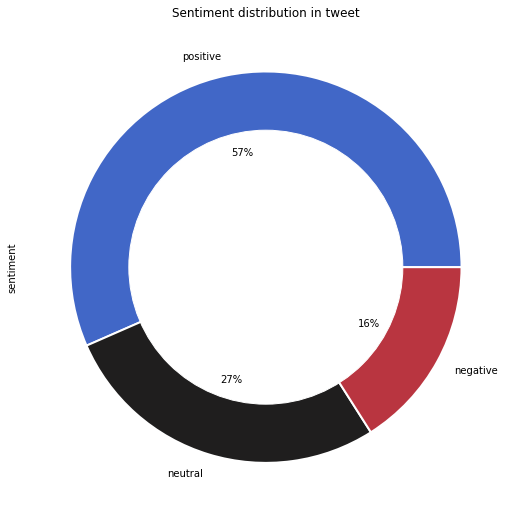

In [53]:
df1[df1.favorites >= 50]['sentiment'].value_counts().plot.pie(autopct = "%1.0f%%", # Mostrar o valor percentual
                                             colors =sns.color_palette("icefire",3), #icefire
                                             figsize=(9,9),
                                             wedgeprops = {"linewidth":2,"edgecolor":"white"})

my_circ = plt.Circle((0,0),.7,color = "white")
plt.gca().add_artist(my_circ)
plt.title("Sentiment distribution in tweet")
plt.show()

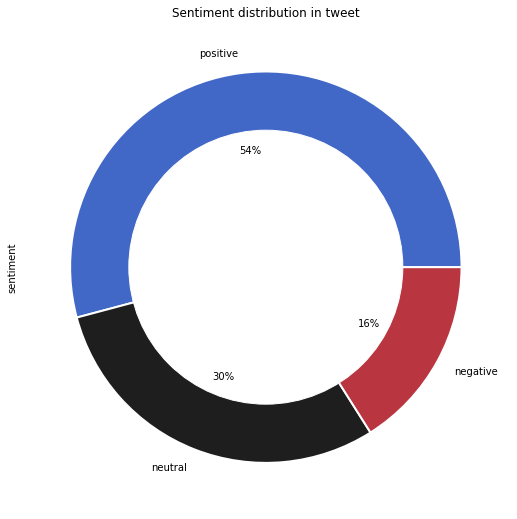

In [54]:
df1['sentiment'].value_counts().plot.pie(autopct = "%1.0f%%", # Mostrar o valor percentual
                                             colors =sns.color_palette("icefire",3), #icefire
                                             figsize=(9,9),
                                             wedgeprops = {"linewidth":2,"edgecolor":"white"})

my_circ = plt.Circle((0,0),.7,color = "white")
plt.gca().add_artist(my_circ)
plt.title("Sentiment distribution in tweet")
plt.show()

Ainda no mérito da variável sentimento, num segundo momento, apresentamos um gráfico de linha mostrando a variação temporal da variável 'gap_sent' para o Manchester City.

<AxesSubplot:xlabel='date'>

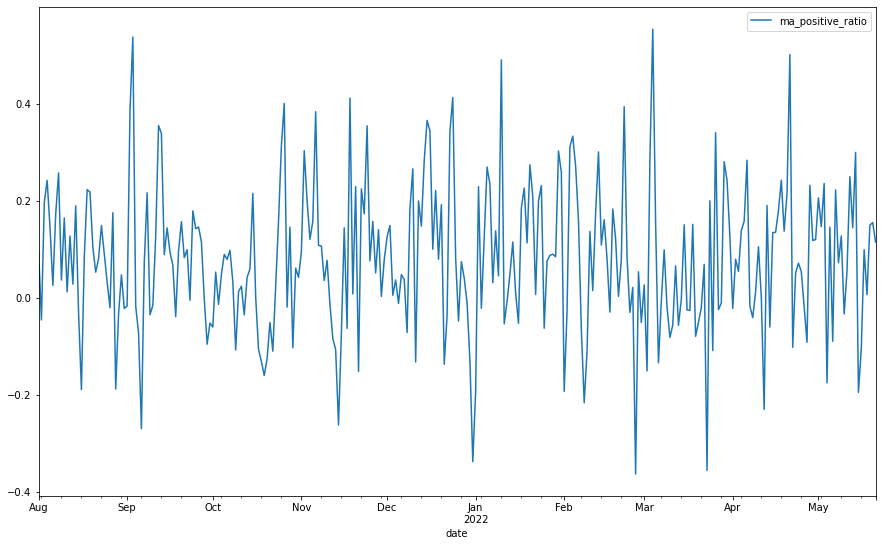

In [33]:
daily_data.loc[(daily_data['team']=='Manchester City')].set_index('date')[['ma_positive_ratio']].plot(figsize=(15,9))

Em seguida, através de uma função de visualização, criamos um word cloud com o nome as palavras mais presentes no tweets de nossa base.

In [55]:
def PL_WordCloud(data,sentiment,image):
    words= []
    stopwords = nltk.corpus.stopwords.words("english")
    for i in data['text'][ data['sentiment']==sentiment].to_list():
        token = nltk.word_tokenize(i)
        for word in token:
            words.append(word)
    words = [ w for w in words if w.isalpha() == True]
    words= [ w for w in words if w not in stopwords]
    wrd = pd.DataFrame(words)
    wrd = wrd[0].unique()
    img = np.array(Image.open("C:\\Users\\guhhh\\OneDrive\\Área de Trabalho\\Workspace\\modeloPL\\image\\"+image+".jpg"))
    wc = WordCloud(background_color="white",scale=2,mask=img,colormap="Dark2",max_words=100).generate(" ".join(wrd))
    fig = plt.figure(figsize=(12,9))
    plt.imshow(wc,interpolation="bilinear")
    plt.axis("off")
    plt.title("Word Cloud Related to the {} ".format(sentiment))
    plt.show()

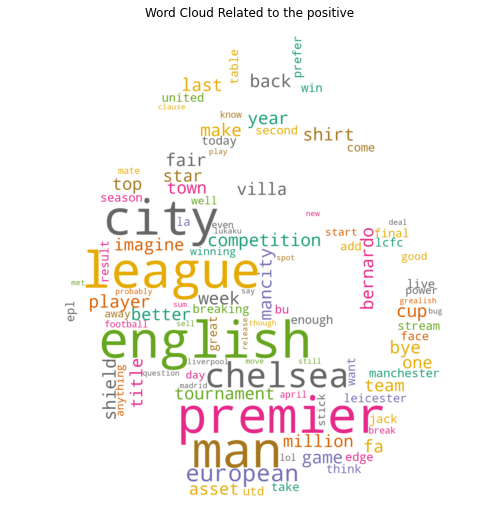

In [56]:
PL_WordCloud(df1, 'positive', 'PL_logo')

Abaixo o gráfico de barra com o nº de gols por clube.

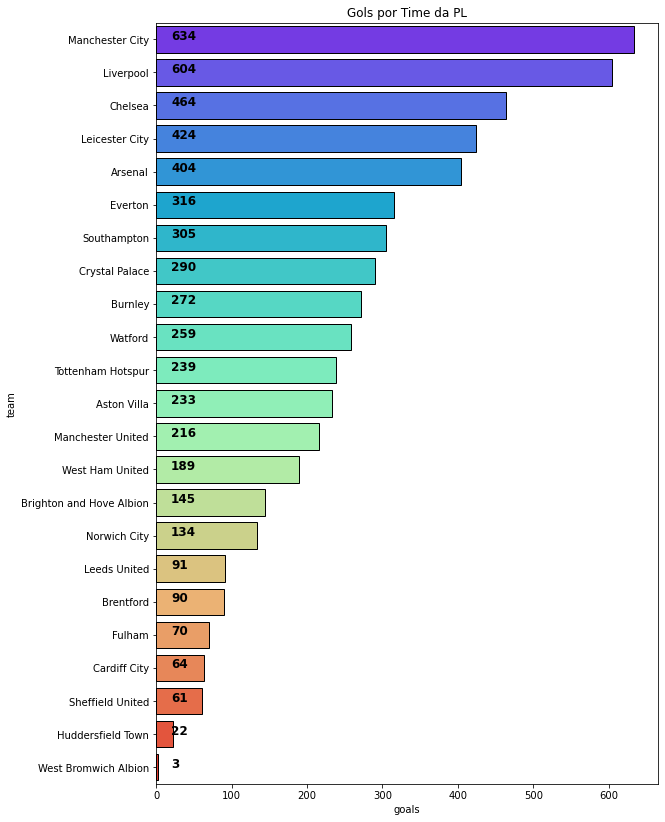

In [57]:
plt.figure(figsize=(9,14))
ax = sns.barplot(x="goals",y="team",
                 data=goals,palette="rainbow",
                linewidth = 1,edgecolor = ['k' for i in range(0,24)])

for i,j in enumerate(goals["goals"][:24]):
    ax.text(20,i,j,weight="bold",color = "k",fontsize =12)

plt.title("Gols por Time da PL")
plt.show()

Aqui seguem as duas visualizações referentes as partidas jogadas entre os clubes de nossa base.
A 1ª consiste num gráfico de teia, onde cada linha representa uma partida. Já a 2ª corresponde a um gráfico de calor, com cada cédula representando a quantidade de partidas disputadas entre os respectivos times dos eixos.

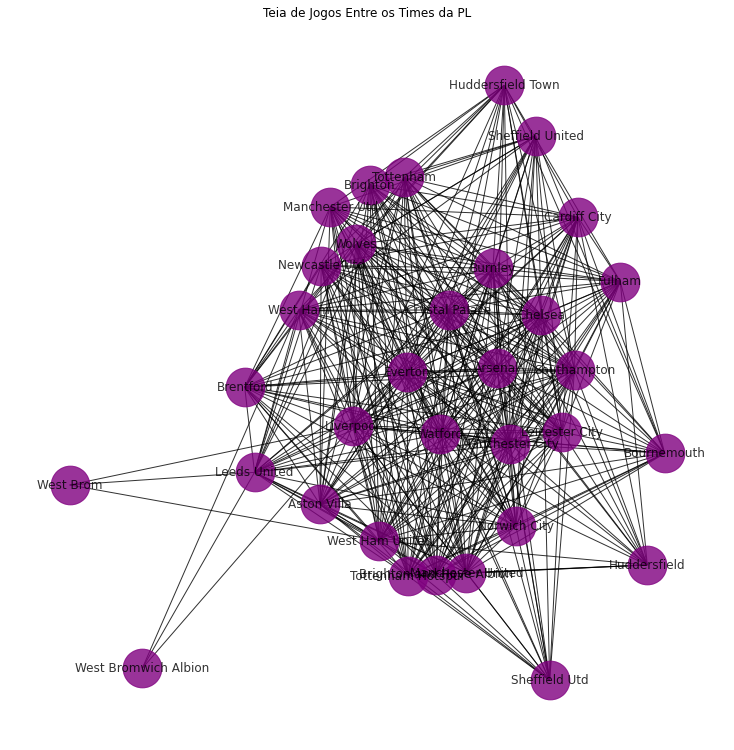

In [65]:
fig = plt.figure(figsize=(10,10))
nx.draw_kamada_kawai(g,with_labels =True,node_size =1500,node_color ="Purple",alpha=.8)
plt.title("Teia de Jogos Entre os Times da PL")
fig.set_facecolor("white")
plt.show()

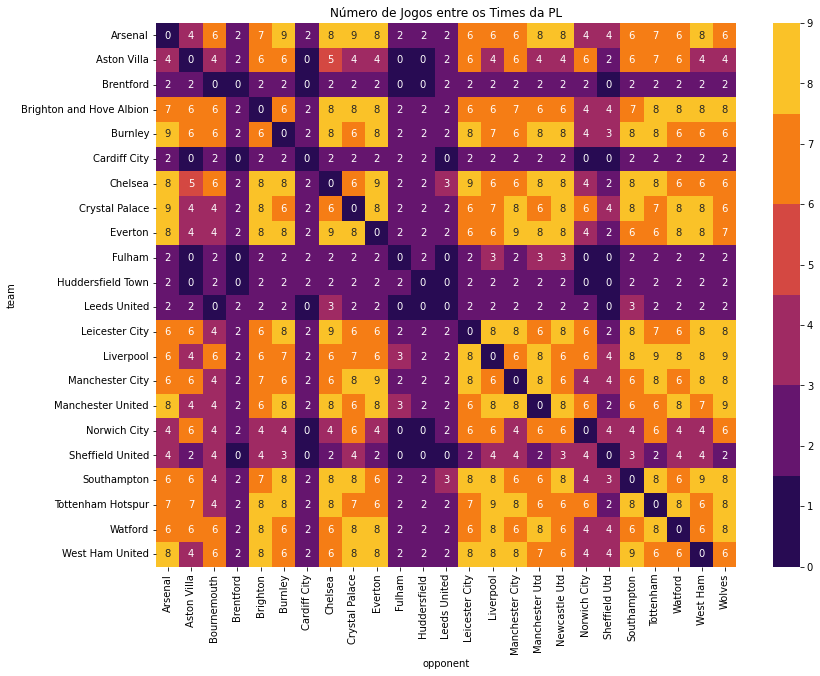

In [64]:
plt.figure(figsize=(13,10))
sns.heatmap(d,annot=True,cmap=sns.color_palette("inferno")) # Opção annot
plt.title("Número de Jogos entre os Times da PL")
plt.show()

Por fim, segue nossa função de comparação dos times, construida apartir do df auxiliar normalizado criado acima.

In [71]:
def team_comparator(team1,team2):
    
    team_list = [team1,team2]
    length    = len(team_list)
    cr        = ["b","r"]
    fig = plt.figure(figsize=(9,9))
    plt.subplot(111,projection= "polar")
    
    for i,j,k in zip(team_list,range(length),cr):
        cats = num_cols
        N    = len(cats)
        
        values = n[n["team"] ==  i][cats].values.flatten().tolist()
        values += values[:1]
        
        angles = [n/float(N)*2*pi for n in range(N)]
        angles += angles[:1]
        
        plt.xticks(angles[:-1],cats,color="k",fontsize=15)
        plt.plot(angles,values,linewidth=3,color=k)
        plt.fill(angles,values,color = k,alpha=.4,label = i)
        plt.legend(loc="best",frameon =True,prop={"size":15}).get_frame().set_facecolor("lightgrey")
        fig.set_facecolor("w")
        fig.set_edgecolor("k")
        plt.title("Comparador dos Times da PL",fontsize=30,color="tomato")

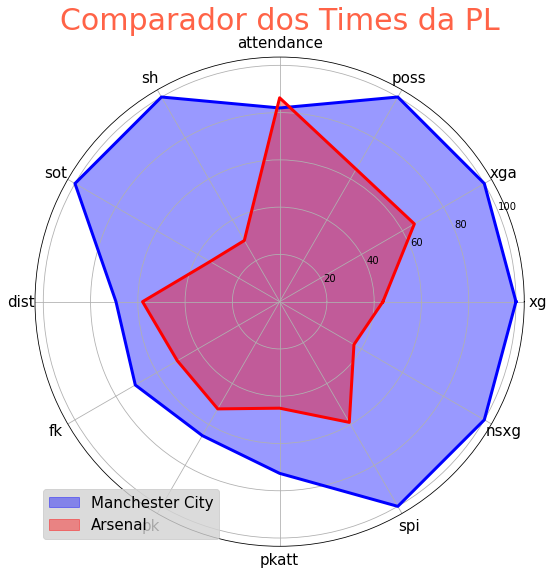

In [72]:
team_comparator('Manchester City','Arsenal')

## Construção do Modelo Preditivo

Num primeiro momento, ordenamos nosso df das partidas pela data, de modo a visualizar o ponto inicial e o ponto final de nosso corte de tempo.

In [73]:
matches.sort_values('date')

,date,time,comp,day,venue,result,gf,ga,opponent,xg,...,sot,dist,fk,pk,pkatt,season,team,spi,nsxg,winner
1987,2018-08-10,20:00,Premier League,Fri,Away,L,1,2,Manchester Utd,1.0,...,4.0,20.2,0.0,0.0,0.0,2019,Leicester City,69.64,1.80,Manchester Utd
1911,2018-08-10,20:00,Premier League,Fri,Home,W,2,1,Leicester City,1.7,...,5.0,19.0,0.0,1.0,1.0,2019,Manchester United,82.66,0.71,Manchester United
2215,2018-08-11,15:00,Premier League,Sat,Away,L,0,2,Watford,0.2,...,0.0,16.8,1.0,0.0,0.0,2019,Brighton and Hove Albion,63.08,0.98,Watford
2253,2018-08-11,15:00,Premier League,Sat,Away,L,0,2,Bournemouth,1.2,...,1.0,12.9,1.0,0.0,0.0,2019,Cardiff City,59.47,1.16,Bournemouth
1835,2018-08-11,12:30,Premier League,Sat,Away,W,2,1,Newcastle Utd,2.0,...,6.0,14.7,1.0,0.0,0.0,2019,Tottenham Hotspur,85.75,1.50,Tottenham Hotspur
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113,2022-05-22,16:00,Premier League,Sun,Home,W,2,1,Watford,2.4,...,8.0,16.3,0.0,0.0,0.0,2022,Chelsea,88.30,1.72,Chelsea
569,2022-05-22,16:00,Premier League,Sun,Away,W,2,1,Brentford,1.4,...,5.0,23.6,0.0,1.0,1.0,2022,Leeds United,62.24,0.94,Leeds United
493,2022-05-22,16:00,Premier League,Sun,Away,L,1,4,Leicester City,1.2,...,1.0,17.7,1.0,1.0,1.0,2022,Southampton,63.59,1.13,Leicester City
265,2022-05-22,16:00,Premier League,Sun,Away,L,1,3,Brighton,0.3,...,2.0,22.8,0.0,0.0,0.0,2022,West Ham United,74.62,0.61,Brighton


Em sequência, criamos nossa variável de interesse e ajustamos alguns de nossos preditores, criando variáveis adicionais categóricas e compatibilizadas.

In [74]:
matches["target"] = (matches["result"] == "W").astype("int")
matches["venue_code"] = matches["venue"].astype("category").cat.codes
matches["opp_code"] = matches["opponent"].astype("category").cat.codes
matches["hour"] = matches["time"].str.replace(":.+", "", regex=True).astype("int")
matches["day_code"] = matches["date"].dt.dayofweek
matches

,date,time,comp,day,venue,result,gf,ga,opponent,xg,...,season,team,spi,nsxg,winner,target,venue_code,opp_code,hour,day_code
0,2021-08-15,16:30,Premier League,Sun,Away,L,0,1,Tottenham,1.9,...,2022,Manchester City,91.76,2.03,Tottenham,0,0,21,16,6
1,2021-08-21,15:00,Premier League,Sat,Home,W,5,0,Norwich City,2.7,...,2022,Manchester City,91.64,2.12,Manchester City,1,1,18,15,5
2,2021-08-28,12:30,Premier League,Sat,Home,W,5,0,Arsenal,3.8,...,2022,Manchester City,92.21,3.47,Manchester City,1,1,0,12,5
3,2021-09-11,15:00,Premier League,Sat,Away,W,1,0,Leicester City,2.9,...,2022,Manchester City,93.26,2.60,Manchester City,1,0,13,15,5
4,2021-09-18,15:00,Premier League,Sat,Home,D,0,0,Southampton,1.1,...,2022,Manchester City,93.48,1.99,Draw,0,1,20,15,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2362,2019-04-13,12:30,Premier League,Sat,Away,L,0,4,Tottenham,0.6,...,2019,Huddersfield Town,52.04,0.73,Tottenham,0,0,21,12,5
2363,2019-04-20,15:00,Premier League,Sat,Home,L,1,2,Watford,0.8,...,2019,Huddersfield Town,51.83,0.63,Watford,0,1,22,15,5
2364,2019-04-26,20:00,Premier League,Fri,Away,L,0,5,Liverpool,0.1,...,2019,Huddersfield Town,51.84,0.19,Liverpool,0,0,14,20,4
2365,2019-05-05,14:00,Premier League,Sun,Home,D,1,1,Manchester Utd,1.1,...,2019,Huddersfield Town,51.35,0.77,Draw,0,1,16,14,6


Aqui, criamos um objeto com nosso modelo de machine learning. Usaremos o método "Random Forest" para treinar o modelo.

In [75]:
rf = RandomForestClassifier(n_estimators=50, min_samples_split=10, random_state=1)

Criamos aqui duas sub amostras, sendo uma para treino e outra para teste do nosso modelo, dividindo nosso df entre observações anteriores e observações posteriores ao 1º dia do ano de 2022.

In [116]:
train = matches[matches["date"] < '2022-01-01']
test = matches[matches["date"] > '2022-01-01']
predictors = ["venue_code", "opp_code", "hour", "day_code", "spi", "nsxg"]

Rodamos então nosso modelo.

In [117]:
rf.fit(train[predictors], train["target"])

RandomForestClassifier(min_samples_split=10, n_estimators=50, random_state=1)

In [118]:
preds = rf.predict(test[predictors])

In [119]:
error = accuracy_score(test["target"], preds)
error

0.6790830945558739

Em seu resultado preeliminar, ele apresenta uma acurácia de 67,9%.

In [120]:
combined = pd.DataFrame(dict(actual=test["target"], predicted=preds))
pd.crosstab(index=combined["actual"], columns=combined["predicted"])

predicted,0,1
actual,,
0,180,34
1,78,57


In [121]:
precision_score(test["target"], preds)

0.6263736263736264

Testando alguns ajustes.

In [122]:
grouped_matches = matches.groupby("team")
group = grouped_matches.get_group("Manchester City").sort_values("date")
group

,date,time,comp,day,venue,result,gf,ga,opponent,xg,...,season,team,spi,nsxg,winner,target,venue_code,opp_code,hour,day_code
1721,2018-08-12,16:00,Premier League,Sun,Away,W,2,0,Arsenal,1.8,...,2019,Manchester City,92.13,1.26,Manchester City,1,0,0,16,6
1722,2018-08-19,13:30,Premier League,Sun,Home,W,6,1,Huddersfield,3.4,...,2019,Manchester City,92.53,3.95,Manchester City,1,1,11,13,6
1723,2018-08-25,12:30,Premier League,Sat,Away,D,1,1,Wolves,1.5,...,2019,Manchester City,92.69,2.54,Draw,0,0,25,12,5
1724,2018-09-01,17:30,Premier League,Sat,Home,W,2,1,Newcastle Utd,2.6,...,2019,Manchester City,92.43,2.34,Manchester City,1,1,17,17,5
1725,2018-09-15,15:00,Premier League,Sat,Home,W,3,0,Fulham,4.1,...,2019,Manchester City,92.22,3.82,Manchester City,1,1,10,15,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33,2022-04-30,17:30,Premier League,Sat,Away,W,4,0,Leeds United,2.7,...,2022,Manchester City,93.65,2.42,Manchester City,1,0,12,17,5
34,2022-05-08,16:30,Premier League,Sun,Home,W,5,0,Newcastle Utd,3.1,...,2022,Manchester City,93.50,3.12,Manchester City,1,1,17,16,6
35,2022-05-11,20:15,Premier League,Wed,Away,W,5,1,Wolves,3.1,...,2022,Manchester City,93.60,1.59,Manchester City,1,0,25,20,2
36,2022-05-15,14:00,Premier League,Sun,Away,D,2,2,West Ham,2.5,...,2022,Manchester City,93.69,2.87,Draw,0,0,24,14,6


In [123]:
def rolling_averages(group, cols, new_cols):
    group = group.sort_values("date")
    rolling_stats = group[cols].rolling(3, closed='left').mean()
    group[new_cols] = rolling_stats
    group = group.dropna(subset=new_cols)
    return group

In [124]:
cols = ["gf", "ga", "sh", "sot", "dist", "fk", "pk", "pkatt", "spi", "nsxg"]
new_cols = [f"{c}_rolling" for c in cols]

rolling_averages(group, cols, new_cols)

,date,time,comp,day,venue,result,gf,ga,opponent,xg,...,gf_rolling,ga_rolling,sh_rolling,sot_rolling,dist_rolling,fk_rolling,pk_rolling,pkatt_rolling,spi_rolling,nsxg_rolling
1724,2018-09-01,17:30,Premier League,Sat,Home,W,2,1,Newcastle Utd,2.6,...,3.000000,0.666667,22.333333,9.000000,17.933333,1.000000,0.000000,0.000000,92.450000,2.583333
1725,2018-09-15,15:00,Premier League,Sat,Home,W,3,0,Fulham,4.1,...,3.000000,1.000000,24.666667,9.333333,17.800000,1.666667,0.000000,0.000000,92.550000,2.943333
1726,2018-09-22,15:00,Premier League,Sat,Away,W,5,0,Cardiff City,2.5,...,2.000000,0.666667,23.333333,7.666667,17.100000,1.666667,0.000000,0.000000,92.446667,2.900000
1727,2018-09-29,15:00,Premier League,Sat,Home,W,2,0,Brighton,3.0,...,3.333333,0.333333,24.333333,9.000000,15.533333,1.666667,0.000000,0.000000,92.313333,3.140000
1728,2018-10-07,16:30,Premier League,Sun,Away,D,0,0,Liverpool,1.2,...,3.333333,0.000000,25.000000,9.000000,15.100000,0.666667,0.000000,0.000000,92.570000,3.853333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33,2022-04-30,17:30,Premier League,Sat,Away,W,4,0,Leeds United,2.7,...,3.333333,1.000000,16.000000,5.333333,16.700000,0.333333,0.333333,0.333333,93.260000,1.960000
34,2022-05-08,16:30,Premier League,Sun,Home,W,5,0,Newcastle Utd,3.1,...,4.000000,0.333333,18.666667,6.000000,16.333333,0.000000,0.333333,0.333333,93.336667,2.286667
35,2022-05-11,20:15,Premier League,Wed,Away,W,5,1,Wolves,3.1,...,4.666667,0.333333,20.000000,7.333333,15.166667,0.333333,0.333333,0.333333,93.443333,2.620000
36,2022-05-15,14:00,Premier League,Sun,Away,D,2,2,West Ham,2.5,...,4.666667,0.333333,18.333333,6.666667,14.933333,0.333333,0.000000,0.000000,93.583333,2.376667


In [125]:
matches_rolling = matches.groupby("team").apply(lambda x: rolling_averages(x, cols, new_cols))
matches_rolling = matches_rolling.droplevel('team')
matches_rolling.index = range(matches_rolling.shape[0])
matches_rolling

,date,time,comp,day,venue,result,gf,ga,opponent,xg,...,gf_rolling,ga_rolling,sh_rolling,sot_rolling,dist_rolling,fk_rolling,pk_rolling,pkatt_rolling,spi_rolling,nsxg_rolling
0,2018-09-02,13:30,Premier League,Sun,Away,W,3,2,Cardiff City,1.5,...,1.666667,2.000000,13.666667,6.333333,17.933333,0.333333,0.000000,0.000000,81.296667,1.653333
1,2018-09-15,15:00,Premier League,Sat,Away,W,2,1,Newcastle Utd,1.1,...,2.666667,2.000000,16.333333,9.000000,16.966667,0.333333,0.000000,0.000000,80.940000,2.003333
2,2018-09-23,16:00,Premier League,Sun,Home,W,2,0,Everton,0.9,...,2.666667,1.333333,15.333333,7.666667,16.600000,0.666667,0.000000,0.000000,80.693333,1.856667
3,2018-09-29,15:00,Premier League,Sat,Home,W,2,0,Watford,1.6,...,2.333333,1.000000,12.666667,6.000000,16.366667,0.333333,0.000000,0.000000,80.546667,1.943333
4,2018-10-07,12:00,Premier League,Sun,Away,W,5,1,Fulham,1.5,...,2.000000,0.333333,10.000000,3.000000,15.800000,0.333333,0.000000,0.000000,80.686667,1.663333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2293,2022-04-24,14:00,Premier League,Sun,Away,L,0,1,Chelsea,0.5,...,1.000000,1.333333,12.333333,4.000000,16.833333,0.666667,0.000000,0.000000,73.316667,1.350000
2294,2022-05-01,16:30,Premier League,Sun,Home,L,1,2,Arsenal,0.4,...,0.333333,1.333333,10.666667,3.333333,15.033333,0.000000,0.000000,0.000000,72.696667,1.176667
2295,2022-05-08,14:00,Premier League,Sun,Away,W,4,0,Norwich City,3.1,...,0.666667,1.333333,11.666667,4.000000,14.066667,0.000000,0.000000,0.000000,72.313333,1.163333
2296,2022-05-15,14:00,Premier League,Sun,Home,D,2,2,Manchester City,1.3,...,1.666667,1.000000,8.666667,3.333333,13.833333,0.000000,0.333333,0.333333,72.236667,0.863333


In [126]:
def make_predictions(data, predictors):
    train = data[data["date"] < '2022-01-01']
    test = data[data["date"] > '2022-01-01']
    rf.fit(train[predictors], train["target"])
    preds = rf.predict(test[predictors])
    combined = pd.DataFrame(dict(actual=test["target"], predicted=preds), index=test.index)
    error = precision_score(test["target"], preds)
    return combined, error
combined, error = make_predictions(matches_rolling, predictors + new_cols)
error

0.6091954022988506

In [127]:
combined = combined.merge(matches_rolling[["date", "team", "opponent", "result"]], left_index=True, right_index=True)
combined.head(10)

,actual,predicted,date,team,opponent,result
115,0,1,2022-01-23,Arsenal,Burnley,D
116,1,0,2022-02-10,Arsenal,Wolves,W
117,1,1,2022-02-19,Arsenal,Brentford,W
118,1,0,2022-02-24,Arsenal,Wolves,W
119,1,0,2022-03-06,Arsenal,Watford,W
120,1,0,2022-03-13,Arsenal,Leicester City,W
121,0,0,2022-03-16,Arsenal,Liverpool,L
122,1,0,2022-03-19,Arsenal,Aston Villa,W
123,0,0,2022-04-04,Arsenal,Crystal Palace,L
124,0,1,2022-04-09,Arsenal,Brighton,L


In [128]:
class MissingDict2(dict):
    __missing__ = lambda self, key: key

map_values2 = {"Brighton and Hove Albion": "Brighton",
              "Manchester United": "Manchester Utd",
              "Newcastle United": "Newcastle Utd",
              "Tottenham Hotspur": "Tottenham",
              "West Ham United": "West Ham",
              "Wolverhampton Wanderers": "Wolves"} 
mapping2 = MissingDict2(**map_values2)

In [129]:
combined["new_team"] = combined["team"].map(mapping2)
merged = combined.merge(combined, left_on=["date", "new_team"], right_on=["date", "opponent"])
merged

,actual_x,predicted_x,date,team_x,opponent_x,result_x,new_team_x,actual_y,predicted_y,team_y,opponent_y,result_y,new_team_y
0,0,1,2022-01-23,Arsenal,Burnley,D,Arsenal,0,0,Burnley,Arsenal,D,Burnley
1,1,1,2022-02-19,Arsenal,Brentford,W,Arsenal,0,0,Brentford,Arsenal,L,Brentford
2,1,0,2022-03-06,Arsenal,Watford,W,Arsenal,0,0,Watford,Arsenal,L,Watford
3,1,0,2022-03-13,Arsenal,Leicester City,W,Arsenal,0,0,Leicester City,Arsenal,L,Leicester City
4,0,0,2022-03-16,Arsenal,Liverpool,L,Arsenal,1,1,Liverpool,Arsenal,W,Liverpool
...,...,...,...,...,...,...,...,...,...,...,...,...,...
307,0,0,2022-04-24,West Ham United,Chelsea,L,West Ham,1,1,Chelsea,West Ham,W,Chelsea
308,0,0,2022-05-01,West Ham United,Arsenal,L,West Ham,1,0,Arsenal,West Ham,W,Arsenal
309,1,0,2022-05-08,West Ham United,Norwich City,W,West Ham,0,0,Norwich City,West Ham,L,Norwich City
310,0,0,2022-05-15,West Ham United,Manchester City,D,West Ham,0,1,Manchester City,West Ham,D,Manchester City


In [130]:
merged[(merged["predicted_x"] == 1) & (merged["predicted_y"] == 0)]["actual_x"].value_counts()

1    47
0    27
Name: actual_x, dtype: int64

In [115]:
47/74

0.6351351351351351

Por fim, a maior acurácia em encontrada no modelo sem ajustes.